In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

In [5]:
df = pd.read_table('nyt_data_counts_enh0221_concat.tsv', header=None, names=['id', 'author_gender', 'year', 'month',
                                                             'sections', 'tags', 'dist_m', 'dist_f',
                                                             'ment_m', 'ment_f', 'quotes_m', 'quotes_f', 
                                                             'quoted_words_m', 'quoted_words_f'])
df = df[df['year'] >= 1988]

In [6]:
sect_counts = defaultdict(int)
section_lists = [a for a in df['sections']]
for i, section_list in enumerate(section_lists):
    try:
        sections = section_list.split('; ')
    except:
        assert type(section_list) is float, section_list
    for section in sections:
        sect_counts[section] += 1

In [7]:
print sorted([(k, v) for (k, v) in sect_counts.iteritems()], key=lambda x: sect_counts[x[0]], reverse=True)

[('New York and Region', 49312), ('Front Page', 41756), ('Business', 41509), ('U.S.', 18739), ('World', 15499), ('Sports', 15203), ('Arts', 12076), ('Washington', 10415), ('Health', 9310), ('Technology', 8756), ('Education', 5719), ('Style', 4895), ('Movies', 4031), ('Home and Garden', 3900), ('Real Estate', 3397), ('Science', 3327), ('Books', 3143), ('Theater', 2643), ('Week in Review', 1857), ('Automobiles', 1264), ('Dining and Wine', 1113), ('Travel', 896), ('Job Market', 577), ('Corrections', 458), ("Editors' Notes", 428), ('Obituaries', 273), ('Magazine', 56), ('Opinion', 41), ('Paid Death Notices', 26)]


In [73]:
for key in sect_counts:
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    print key, len(sect_df)

Arts 13017
Editors' Notes 428
Job Market 625
Travel 984
Style 5221
Sports 16272
Week in Review 1937
Health 9681
Front Page 43164
Business 42674
Automobiles 1327
Home and Garden 4011
Obituaries 279
World 15933
Theater 2745
Paid Death Notices 26
Science 3444
U.S. 19332
Movies 4306
Magazine 55
New York and Region 51042
Corrections 459
Opinion 41
Dining and Wine 1207
Washington 10634
Books 3352
Real Estate 3469
Education 5892
Technology 9110


In [8]:
df.describe()

,year,month,dist_m,dist_f,ment_m,ment_f,quotes_m,quotes_f,quoted_words_m,quoted_words_f
count,170416.000000,170416.000000,170171.000000,170171.000000,170171.000000,170171.000000,170171.000000,170171.000000,170171.000000,170171.000000
mean,1996.989531,6.462897,4.787426,1.303248,13.561529,3.337549,4.787426,1.303248,20.986807,6.071264
std,5.095959,3.483906,4.139756,2.147643,15.262252,7.310478,4.139756,2.147643,62.513354,33.333298
min,1988.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1993.000000,3.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,1997.000000,6.000000,4.000000,1.000000,9.000000,1.000000,4.000000,1.000000,0.000000,0.000000
75%,2002.000000,10.000000,7.000000,2.000000,19.000000,3.000000,7.000000,2.000000,0.000000,0.000000
max,2005.000000,12.000000,93.000000,55.000000,255.000000,193.000000,93.000000,55.000000,1120.000000,1355.000000


In [14]:
def display_table(groupedby):
    """
    Take a grouped by object and display summaries of counts, sums and
    ratios across it.
    """
    agg_dict = OrderedDict([('month', {'count': 'count'})] + [
        (col, {'sum': np.sum}) for col in ['dist_m', 'dist_f', 'ment_m', 'ment_f', 'quotes_m', 'quotes_f',
                                           'quoted_words_m', 'quoted_words_f']])
    agg_table = groupedby.aggregate(agg_dict)
    for counts in ['dist', 'ment', 'quotes', 'quoted_words']:
        sum_ = agg_table[counts + '_m'] + agg_table[counts + '_f']
        for gend in ['f']:
            agg_table['{}_{}_ratio'.format(counts, gend)] = agg_table[counts + '_' + gend]/sum_
    return agg_table

In [31]:
def plot_ratio_over_time(df, criterion, gender, desc='', only_women=False):
    """
    Criterion is something like 'ment', 'dist' or 'quotes'
    gender is 'm' or 'f'.
    This is a plot of how the ratio of that gender's counts
    in criterion have changed over time.
    """
    gender = gender.lower()[0]
    gender_to_string = {
        'm': 'males',
        'f': 'females'
    }
    criterion_to_string = {
        'ment': 'Total mentions',
        'dist': 'Mentions in articles',
        'quotes': 'People Quoted',
        'quoted_words': 'Quoted words'
    }
    gb_y = df.groupby(['year'])
    gb_gend = df.groupby(['author_gender'])
    plot_col = '{}_{}_ratio'.format(criterion, gender)
    agg_table_y = display_table(gb_y)
    ri = agg_table_y.reset_index()
    
    fig, ax = plt.subplots()
    # Be sure to only pick integer tick locations.
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # plt.gca().xaxis.set_ticklabels([str(a) for a in list(ri['year'])])
    plt.plot(ri['year'], ri[plot_col], label=desc if only_women else 'Total')
    # print ri['year'], '\n'.join([str(a) for a in ri[plot_col]])

    plt.xlabel('Year')
    if criterion == 'quoted_words':
        plt.ylabel('Fraction of words spoken by women')
    else:
        plt.ylabel('Fraction of {} among {}{}'.format(gender_to_string[gender], criterion_to_string[criterion],
                  ' in {}'.format(desc) if desc and not only_women else ''))
    if not only_women:
        for key, grp in df.groupby(['author_gender']):
            if key not in ['MALE', 'FEMALE']:
                continue
            table = display_table(grp.groupby(['year']))
            ri = table.reset_index()
            # print key.title()
            # print ri['year'], '\n'.join([str(a) for a in ri[plot_col]])
            plt.plot(ri['year'], ri[plot_col], label = '{} authors'.format(key.title()))
    plt.legend(loc='upper left')

In [18]:
def plot_fraction_women_authors_over_time(df, desc=''):
    gb_year_gend = df.groupby(['year', 'author_gender']).aggregate({'dist_f': {'count': 'count'}}).reset_index()
    ratios = {}
    for year in range(1989, 2006):
        gb_year = gb_year_gend[gb_year_gend['year'] == year]
        counts = {}
        for gend in ['FEMALE', 'MALE']:
            counts[gend] = gb_year[gb_year['author_gender'] == gend].iloc[0][2]
        ratios[year] = float(counts['FEMALE'])/(counts['FEMALE'] + counts['MALE'])
    plt.plot(sorted(ratios), [ratios[year] for year in sorted(ratios)], label=desc)
    plt.title('Fraction of articles written by women over time')
    plt.gcf().set_size_inches(10, 6)
    plt.legend(loc='upper left')
    # plt.savefig('Authors_over_time{}.png'.format('_{}'.format(desc) if desc else ''), dpi=100)

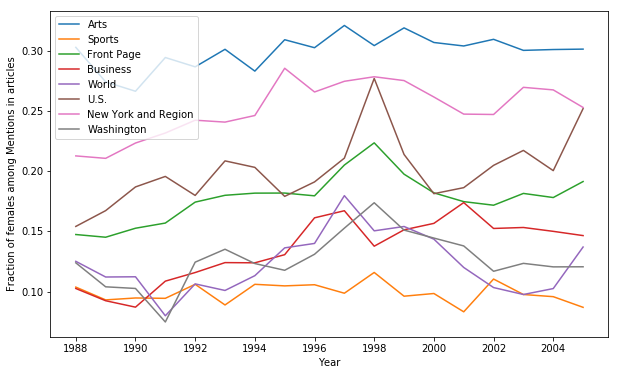

In [19]:
fig, ax = plt.subplots()
# Be sure to only pick integer tick locations.
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
for key in sect_counts:
    

    if sect_counts[key] < 10000:
        continue
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    plot_ratio_over_time(sect_df, 'dist', 'f', key, True)

plt.gcf().set_size_inches(10, 6)
plt.savefig('Distinct_mentions_over_time_for_women.png', dpi=100)


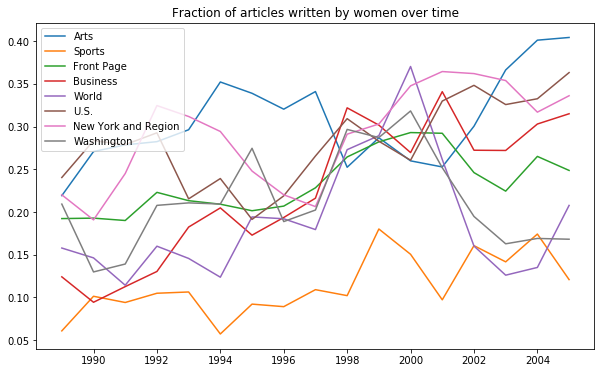

In [20]:
fig, ax = plt.subplots()
# Be sure to only pick integer tick locations.
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
for key in sect_counts:
    if sect_counts[key] < 10000:
        continue
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    plot_fraction_women_authors_over_time(sect_df, key)

plt.gcf().set_size_inches(10, 6)
plt.savefig('Fraction_women_writers_over_time.png', dpi=100)

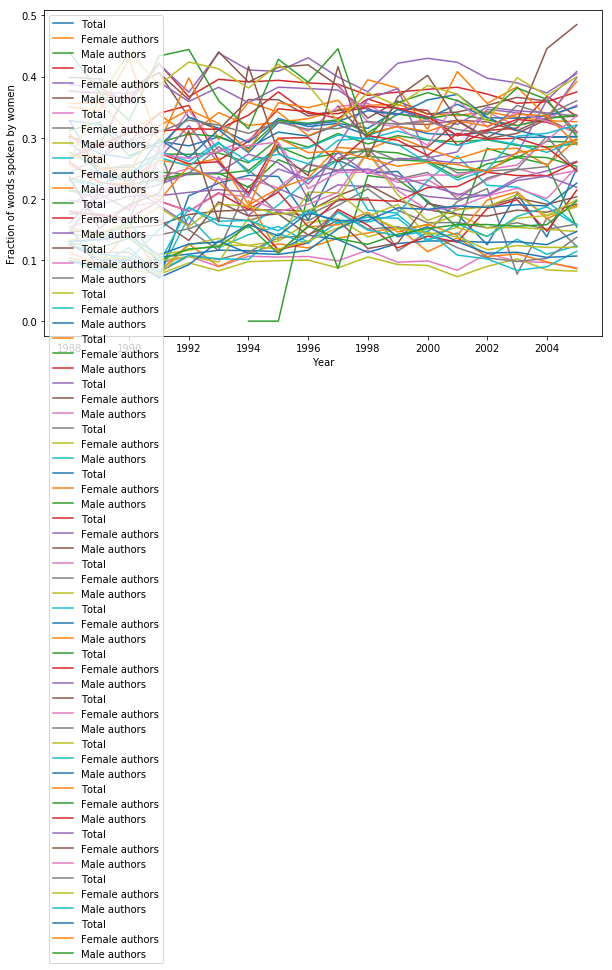

In [22]:
fig, ax = plt.subplots()
# Be sure to only pick integer tick locations.
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
for key in sect_counts:
    

    if sect_counts[key] < 1000:
        continue
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    plot_ratio_over_time(sect_df, 'quotes', 'f')

plt.gcf().set_size_inches(10, 6)
plt.savefig('Quotes_over_time_for_women.png'.format(key), dpi=100)

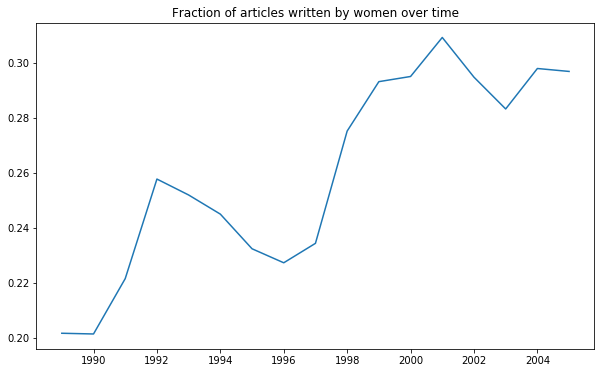

In [41]:
plot_fraction_women_authors_over_time(df, 'Overall')

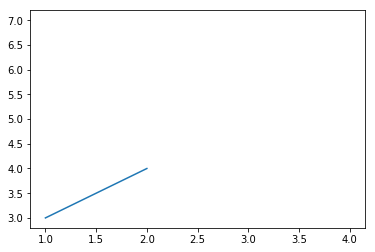

In [52]:
plt.plot([1, 2], [3, 4])
plt.plot([4], [7])

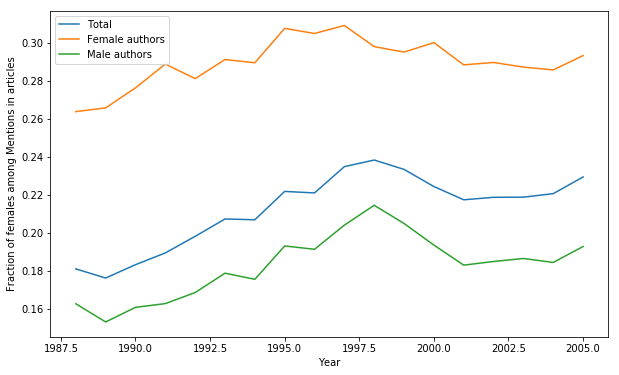

In [23]:
plot_ratio_over_time(df, 'dist', 'f')
plt.gcf().set_size_inches(10, 6)
plt.savefig('Distinct_mentions_over_time_NYT.png', dpi=100)

In [88]:
for key in sect_counts:
    if sect_counts[key] < 5000:
        continue
    sect_df = df[df['sections'].map(lambda s: type(s) is str and key in s)]
    male_quotes = sect_df['quotes_m'].sum()
    female_quotes = sect_df['quotes_f'].sum()
    print key
    # print female_quotes/(male_quotes + female_quotes)

Arts
Style
Sports
Health
Front Page
Business
World
U.S.
New York and Region
Washington
Education
Technology


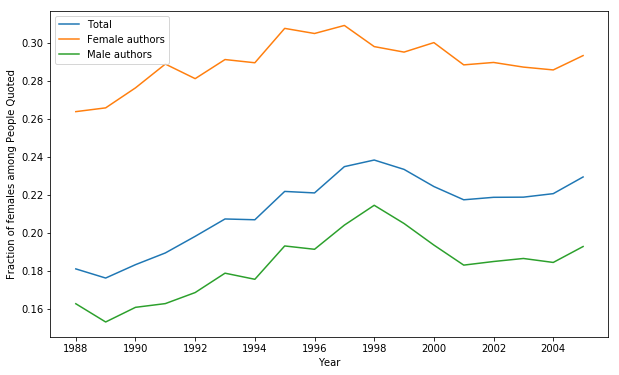

In [30]:
plot_ratio_over_time(df, 'quotes', 'f')
plt.gcf().set_size_inches(10, 6)
plt.savefig('Quotes_over_time_NYT.png', dpi=100)

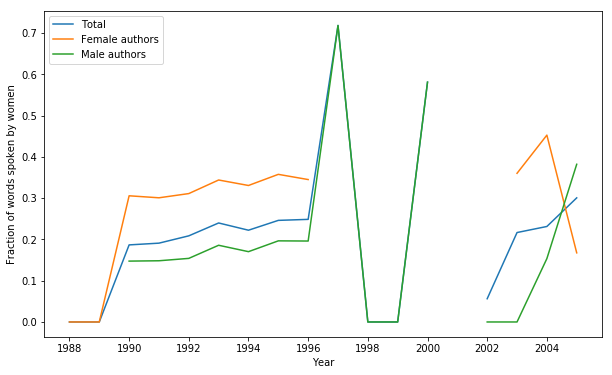

In [29]:
plot_ratio_over_time(df, 'quoted_words', 'f')
plt.gcf().set_size_inches(10, 6)
plt.savefig('Quoted_words_over_time_NYT.png', dpi=100)